In [1]:
import numpy as np
import pandas as pd
import os
import json, ast
from vax_concerns_classifiers import CATEGORIES, DESCRIPTIONS
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

LOCAL_DIR = os.path.join(os.path.dirname(os.getcwd()), 'bert_classifier')
DATA_DIR = os.path.join(LOCAL_DIR, '..', '..', 'data')
full_df = pd.read_csv(os.path.join(DATA_DIR, "full_bert.csv"))

In [2]:
len(full_df)

186669

In [ ]:
def plot_time_series(data, title, xlabel, ylabel, resize=False, legend_names=None):
    plt.figure(figsize=(15, 5))

    # Add title and labels
    if title:
        plt.title(title, fontsize=20, fontweight='bold')
    plt.xlabel(xlabel, fontsize=16, fontweight='bold')
    plt.ylabel(ylabel, fontsize=16, fontweight='bold')

    # Check if data is a Series or DataFrame
    if isinstance(data, pd.Series):
        plt.plot(data.index, data.values, linestyle='-', linewidth=2)
    else:
        if legend_names is None:
            legend_names = data.columns
        for column, label in zip(data.columns, legend_names):
            plt.plot(data.index, data[column], label=label, linestyle='-', linewidth=2)

    # Show legend if applicable
    if legend_names:
        plt.legend(fontsize=14)

    # Set y-axis limits
    plt.ylim(bottom=0)
    if not resize:
        plt.ylim(0, 1)

    # Format x-axis for yearly ticks
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Set x-axis limits
    plt.xlim(data.index.min(), data.index.max())
    ax.tick_params(axis='both', which='major', labelsize=14, width=2)

    plt.show()

def plot_all_time_series(df, x_col, title, y_axis_label, resize=False):
    fig, axes = plt.subplots(len(CATEGORIES), 1, figsize=(15, 3 * len(CATEGORIES)), sharex=False, sharey=False)
    
    for i, ax in enumerate(axes):
        ax.plot(df[x_col], df[CATEGORIES[i]], linestyle='-')
        ax.set_title(f"{title} - {DESCRIPTIONS[i]['cat']}. {DESCRIPTIONS[i]['name']}", fontsize=12)
        ax.set_ylabel(y_axis_label, fontsize=10)
        ax.set_xlabel('Date', fontsize=10)
        if not resize:
            ax.set_ylim(0, 1)
        ax.grid(True)
        
        # Format x-axis for yearly ticks
        ax.xaxis.set_major_locator(mdates.YearLocator(1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    plt.tight_layout()
    plt.show()

In [6]:
df = full_df[['published_time', 'bert_ann', 'article_title']].copy()

# convert to datetime and then bin by month
df['published_time'] = pd.to_datetime(df['published_time'])
df['time_bin'] = df['published_time'].dt.to_period('M')
df['time_bin'] = pd.to_datetime(df['time_bin'].dt.to_timestamp())

# convert labels to a df and concat
df['bert_ann_dict'] = df['bert_ann'].apply(ast.literal_eval)
labels_df = df['bert_ann_dict'].apply(pd.Series)
df = pd.concat([df, labels_df], axis=1)

# drop unecessary columns
df = df.drop(columns=['bert_ann', 'bert_ann_dict'])
df.head()

published_time                                   article_title   time_bin  \
0     2020-11-23  Gratitude: Our Bodies’ Natural Anti-Depressant 2020-11-01   
1     2020-11-23  Gratitude: Our Bodies’ Natural Anti-Depressant 2020-11-01   
2     2020-11-23  Gratitude: Our Bodies’ Natural Anti-Depressant 2020-11-01   
3     2020-11-23  Gratitude: Our Bodies’ Natural Anti-Depressant 2020-11-01   
4     2020-11-23  Gratitude: Our Bodies’ Natural Anti-Depressant 2020-11-01   

     1  1.1  1.2  1.3    2  2.1  2.2  ...  3.4  3.5    4  4.1  4.2    5  5.1  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0   

   5.2  5.3  5.4  
0  0.0  0.0  0.0  
1  0.0  0.0  0.0  
2  0.0  0.0  0.0  
3  0.0  0.0  0.0  
4  1.0  0.0  0.0  

[5 rows x 27 columns]

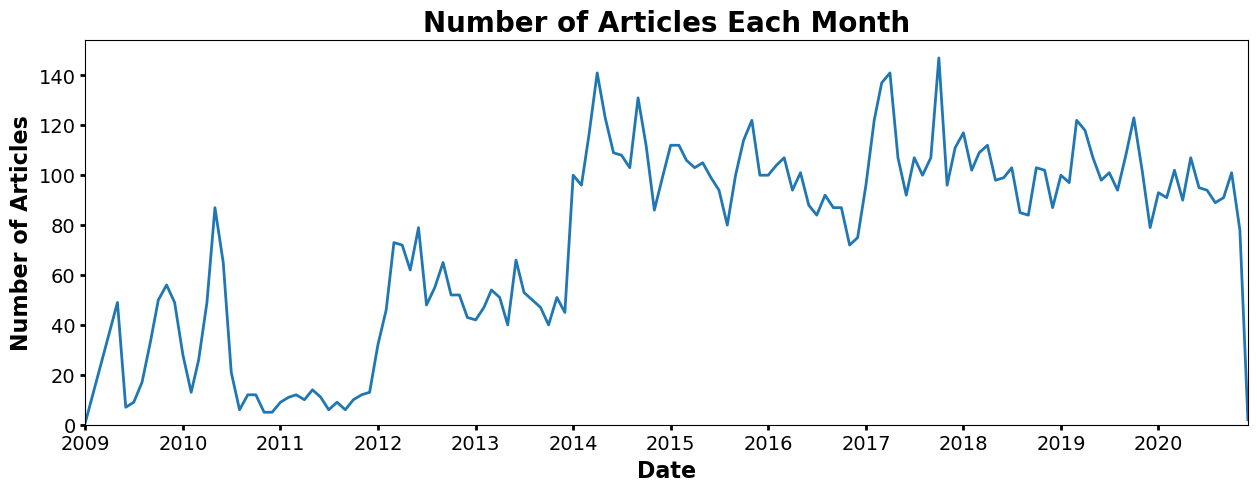

Total number of articles: 10496


In [37]:
# get the number of articles for each month
support = df.groupby("time_bin")["article_title"].nunique()
plot_time_series(support, "Number of Articles Each Month", 'Date', 'Number of Articles', resize=True)
print(f"Total number of articles: {support.sum()}")

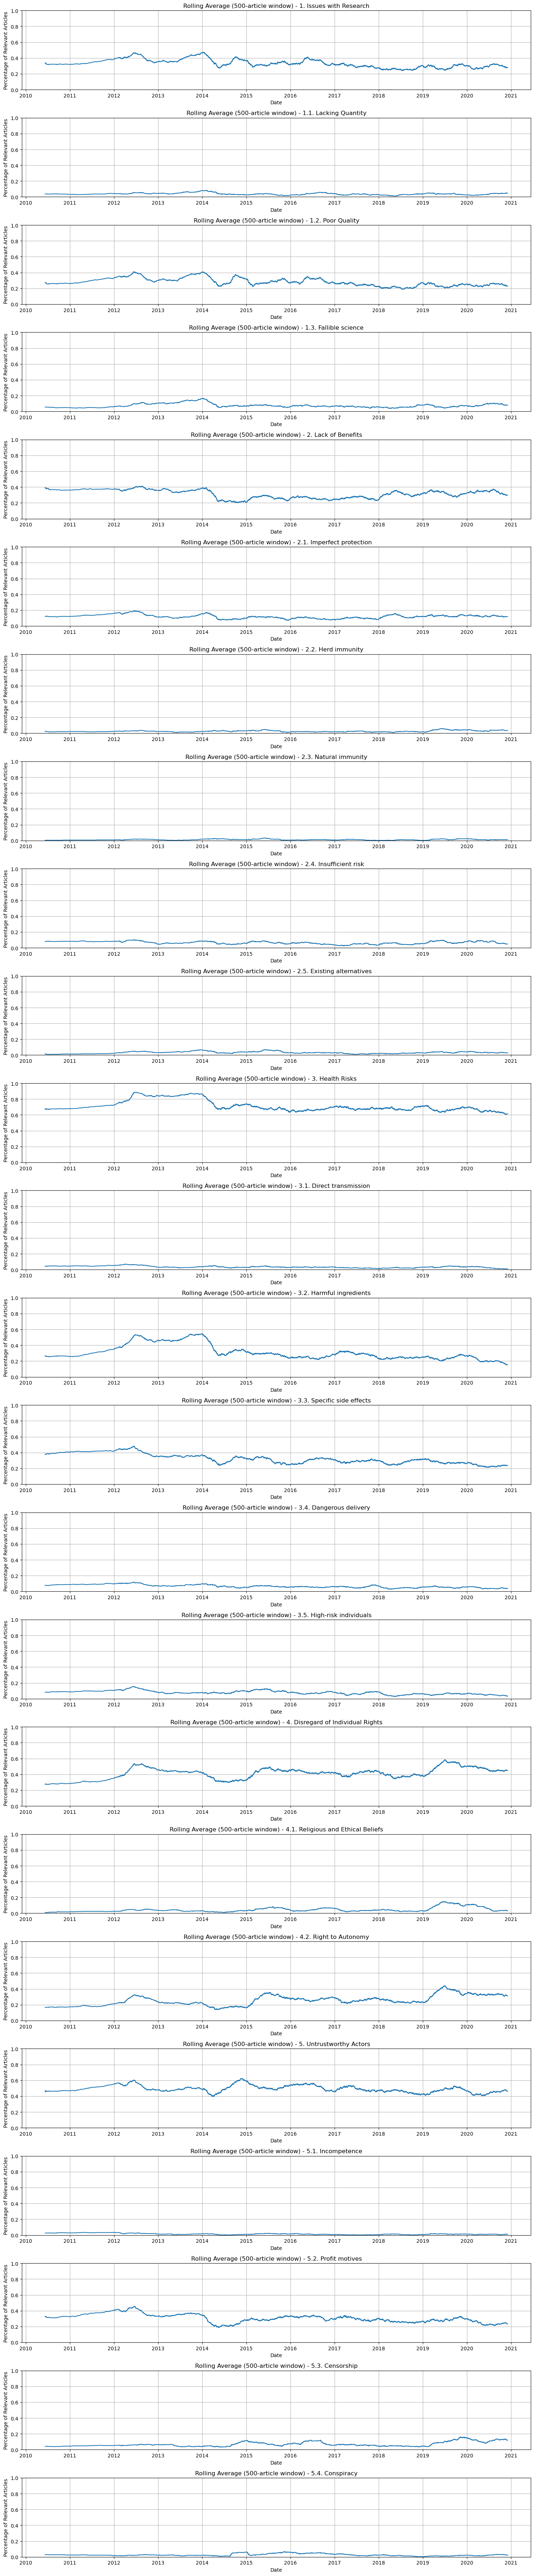

In [52]:
# get rolling average for each concern
rolling_avg = df.groupby('article_title').max(numeric_only=True).reset_index()
rolling_avg = rolling_avg.merge(df[['article_title', 'published_time']].drop_duplicates(), on='article_title')
rolling_avg = rolling_avg.sort_values('published_time')

window = 500
numeric_columns = df.select_dtypes("number").columns
for col in numeric_columns:
    rolling_avg[col] = (rolling_avg[col]
        .rolling(window=window, min_periods=1)
        .mean()
    )
rolling_avg = rolling_avg[window - 1:]

plot_all_time_series(rolling_avg, 'published_time', f'Rolling Average ({window}-article window)', 'Percentage of Relevant Articles', resize=False)

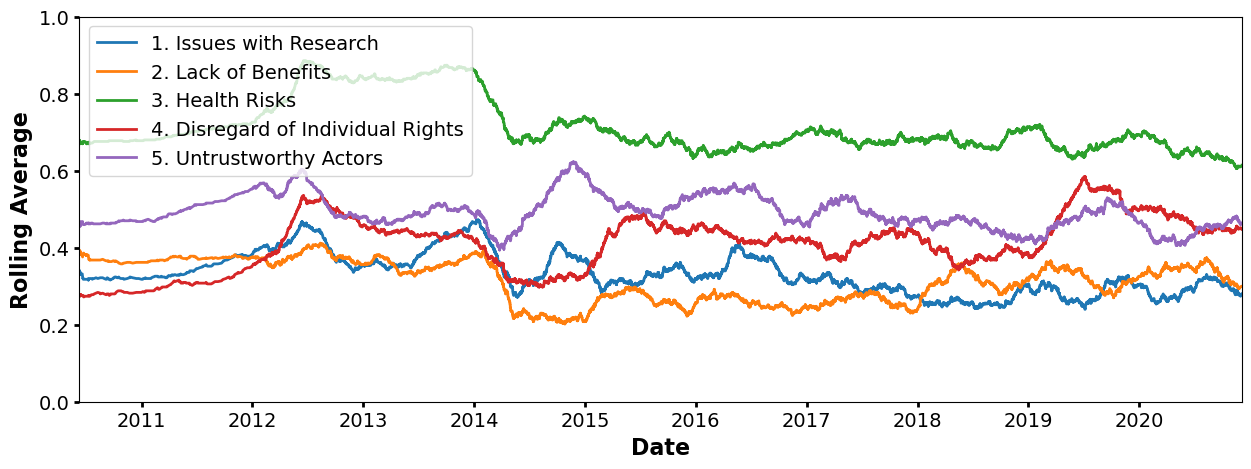

In [66]:
rolling_avg_class = rolling_avg[['published_time', '1', '2', '3', '4', '5']]
rolling_avg_class = rolling_avg_class.set_index('published_time')
# rolling_avg_class = pd.Series(rolling_avg[CATEGORIES[class_idx]].values, index=rolling_avg['published_time'])
legend_names = ['1. Issues with Research','2. Lack of Benefits','3. Health Risks','4. Disregard of Individual Rights','5. Untrustworthy Actors']
plot_time_series(rolling_avg_class, "", 'Date', 'Rolling Average', legend_names=legend_names)

In [54]:
rolling_avg_class.head()

published_time      1      2      3      4      5
7564     2010-06-10  0.340  0.392  0.678  0.278  0.468
8834     2010-06-10  0.338  0.390  0.678  0.276  0.466
7756     2010-06-10  0.336  0.390  0.676  0.274  0.464
3442     2010-06-11  0.336  0.392  0.678  0.274  0.464
6867     2010-06-12  0.336  0.392  0.678  0.274  0.462

In [18]:
# count pre and post covid percentages
covid_year_before = pd.to_datetime('2019-03-01')
end_year_before = pd.to_datetime('2019-12-01')
covid = pd.to_datetime('2020-03-01')
end_cutoff = pd.to_datetime('2020-12-01')

article_relevance = df.groupby('article_title').max(numeric_only=True).reset_index()
article_relevance = article_relevance.merge(df[['article_title', 'published_time']].drop_duplicates(), on='article_title')
article_relevance.head()

pre_covid = article_relevance[(article_relevance['published_time'] >= covid_year_before) & (article_relevance['published_time'] <= end_year_before)]
post_covid = article_relevance[(article_relevance['published_time'] >= covid) & (article_relevance['published_time'] <= end_cutoff)]
print(len(pre_covid), len(post_covid))

pre_covid = pre_covid.mean(numeric_only=True)
post_covid = post_covid.mean(numeric_only=True)

pre_post_covid = pd.concat([pre_covid, post_covid], axis=1) * 100
pre_post_covid.columns = ['Pre-Covid', 'Post-Covid']

pre_post_covid.to_csv("pre_post_covid.csv", index=False)

977 848


In [ ]:
time_bins = df.drop(columns=['published_time']).copy()
# time_bins = df.groupby('time_bin').sum(numeric_only=True).reset_index()
time_bins = df.groupby('article_title').max(numeric_only=True).reset_index()
time_bins = time_bins.merge(df[['article_title', 'time_bin']].drop_duplicates(), on='article_title')
time_bins = time_bins.groupby('time_bin').mean(numeric_only=True).reset_index()

class_idx = 0
class_time_bins = time_bins[['time_bin', CATEGORIES[class_idx]]]

events = [
    # {'date': '2009-04', 'label': 'Swine Flu pandemic'},
    {'date': '2012-06', 'label': 'Middle East respiratory syndrome'},
    {'date': '2013-12', 'label': 'Ebolavirus Disease'},
    {'date': '2015-05', 'label': 'Zika Virus epidemic'},
    {'date': '2019-12', 'label': 'COVID-19'},
]

plt.figure(figsize=(15, 6))
plt.plot(class_time_bins['time_bin'], class_time_bins[CATEGORIES[class_idx]], marker='o', linestyle='-', color='b')

for event in events:
    event_date = pd.to_datetime(event['date'])
    value_at_event = class_time_bins.loc[class_time_bins['time_bin'] == event_date, CATEGORIES[class_idx]].values[0]  # Find value at event date
    plt.annotate(
        event['label'], 
        xy=(event_date, value_at_event),  # Point to the event
        xytext=(event_date, value_at_event + 0.05),  # Text offset
        arrowprops=dict(arrowstyle='->', color='red', lw=1),
        fontsize=12, 
        color='red',
        bbox=dict(boxstyle='round,pad=0.15', edgecolor='black', facecolor='white', lw=1)  # Add white bubble background
    )

plt.title(DESCRIPTIONS[class_idx]['name'], fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()